In [1]:
print("ok")

ok


In [48]:
# configure model
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1",temperature=0)

this is my custom tools


In [49]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """
    Multiply two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """
    Add two integers.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """
    Divide two integers.

    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).

    Returns:
        float: The result of division.
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero.")
    return a / b

importing the inbuilt tool


In [50]:
from langchain_community.tools import DuckDuckGoSearchRun
search=DuckDuckGoSearchRun()

In [ ]:
search.invoke("what is the latest update on iphone17 release?")


In [51]:
tools=[multiply, add, divide, search]


In [52]:
llm_with_tools=model.bind_tools(tools)


In [53]:
response=llm_with_tools.invoke("hi")


In [54]:
response.content


'Hello! How can I help you today?'

In [55]:
response.tool_calls


[]

In [56]:
response=llm_with_tools.invoke("what is 2+2?")


In [57]:
response.content


''

In [58]:
response.tool_calls


[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'call_N42ZBS3nCL4OqyYyxA6hA1on',
  'type': 'tool_call'}]

In [59]:
response=llm_with_tools.invoke("what is 10/2?")


In [60]:
response.content


''

In [61]:
response.tool_calls


[{'name': 'divide',
  'args': {'a': 10, 'b': 2},
  'id': 'call_uQotlYO9pZaWOvG4YJr1COKi',
  'type': 'tool_call'}]

In [62]:
response=llm_with_tools.invoke("what is a current age of the TATA Group?")


In [63]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_C2IgDfVfChQ1cTxIS03tVHcQ', 'function': {'arguments': '{"query":"TATA Group founding year"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 237, 'total_tokens': 258, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BikXPsbibtHQK24smXOMdtNEN2m8k', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d60c8a90-4f8e-4000-93e3-ee91867712ec-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'TATA Group founding year'}, 'id': 'call_C2IgDfVfChQ1cTxIS03tVHcQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 237, 'output_tokens': 21, 

In [64]:
response.content


''

In [65]:
response.tool_calls


[{'name': 'duckduckgo_search',
  'args': {'query': 'TATA Group founding year'},
  'id': 'call_C2IgDfVfChQ1cTxIS03tVHcQ',
  'type': 'tool_call'}]

In [66]:
SYSTEM_PROMPT="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs."


In [67]:
user_query=["tell me what is 2+2"]


In [68]:
[SYSTEM_PROMPT]+user_query


['You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.',
 'tell me what is 2+2']

In [69]:
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }
    

In [70]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

In [71]:
builder=StateGraph(MessagesState)


In [72]:
builder.add_node("llm_decision_step",function_1)


In [73]:
tools

[StructuredTool(name='multiply', description='Multiply two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000026D0084E200>),
 StructuredTool(name='add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000026D0065B420>),
 StructuredTool(name='divide', description='Divide two integers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator (must not be 0).\n\nReturns:\n    float: The result of division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000026D0084DF80>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', 

In [74]:
from langgraph.prebuilt import ToolNode
builder.add_node("tools",ToolNode(tools))

In [75]:
builder.add_edge(START,"llm_decision_step")


In [76]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)

In [77]:
builder.add_edge("tools","llm_decision_step")


In [78]:
react_graph=builder.compile()


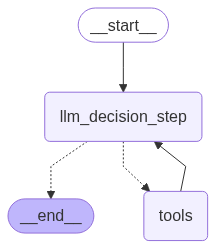

In [79]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [80]:
message=[HumanMessage(content="What is 2 times of narendramodi's age?")]


In [81]:
react_graph.invoke({"messages":message})


{'messages': [HumanMessage(content="What is 2 times of narendramodi's age?", additional_kwargs={}, response_metadata={}, id='a45bad57-3f58-4c49-a152-e5e2daa40d7b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a0Eiu6D8WoYxV7lpPyn8Wqlu', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 261, 'total_tokens': 281, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BikYOrAUDn9txpYhyVnkqIsRJihYT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--168010c5-1dc0-4d06-88a7-5e571fc2cd9d-0', tool_calls=[{'name': 'duckduckgo_search', 'args':

In [82]:
message = [HumanMessage(content="How much is the net worth of Elon Musk, and divide it by 2?")]


In [83]:
react_graph.invoke({"messages":message})


{'messages': [HumanMessage(content='How much is the net worth of Elon Musk, and divide it by 2?', additional_kwargs={}, response_metadata={}, id='b8752984-fd68-45c2-99ca-314f7dea5065'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d0XExvMC4w7QLWPyMEC21d9P', 'function': {'arguments': '{"query":"Elon Musk net worth"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 265, 'total_tokens': 286, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BikZ3SmpCoiE2vjrBZJrTwDUafDnG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--03e30398-d2d4-4b3e-b1ec-2a136ef3ad47-0', tool_calls=[{'name': 'duck

In [84]:
message = [HumanMessage(content="What is the speed of light in m/s and multiply it by 10?")]


In [85]:
response=react_graph.invoke({"messages":message})


In [86]:
response["messages"][-1].content


"The speed of light in a vacuum is a well-known constant: 299,792,458 meters per second (m/s).\n\nNow, let's multiply this value by 10:\n\n299,792,458 × 10 = 2,997,924,580\n\nSo, the speed of light multiplied by 10 is 2,997,924,580 m/s."

In [87]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the speed of light in m/s and multiply it by 10?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_RHzWrPtw8Tx8tEXeTLZwKfpO)
 Call ID: call_RHzWrPtw8Tx8tEXeTLZwKfpO
  Args:
    query: speed of light in m/s
================================= Tool Message =================================
Name: duckduckgo_search

Error: DuckDuckGoSearchException(DuckDuckGoSearchException('https://lite.duckduckgo.com/lite/ RuntimeError: error sending request for url (https://lite.duckduckgo.com/lite/): client error (Connect)\n\nCaused by:\n    0: client error (Connect)\n    1: TLS handshake failed: cert verification failed - unable to get local issuer certificate [CERTIFICATE_VERIFY_FAILED]\n    2: [CERTIFICATE_VERIFY_FAILED]\n    3: [CERTIFICATE_VERIFY_FAILED]'))
 Please fix your mistakes.
================================== Ai Message ==============

In [89]:
import yfinance as yf


In [90]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"
     

In [91]:
get_stock_price.invoke("AAPL")


'An error occurred while fetching stock data: Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.'

In [92]:
tools

[StructuredTool(name='multiply', description='Multiply two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The product of a and b.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000026D0084E200>),
 StructuredTool(name='add', description='Add two integers.\n\nArgs:\n    a (int): The first integer.\n    b (int): The second integer.\n\nReturns:\n    int: The sum of a and b.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x0000026D0065B420>),
 StructuredTool(name='divide', description='Divide two integers.\n\nArgs:\n    a (int): The numerator.\n    b (int): The denominator (must not be 0).\n\nReturns:\n    float: The result of division.', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x0000026D0084DF80>),
 DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', 

In [93]:
tools = [add, multiply, divide, search,get_stock_price]

In [95]:
llm_with_tools=model.bind_tools(tools)


In [96]:
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")


In [97]:
response.content


''

In [98]:
response.tool_calls


[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.BO'},
  'id': 'call_6HwuPqAkz7fyXOAePu5VUgUM',
  'type': 'tool_call'}]

In [99]:
# now try with complex questions related to finanace
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [100]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

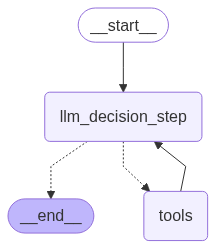

In [101]:
display(Image(react_graph2.get_graph(xray=True).draw_mermaid_png()))


In [102]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [103]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_OuNOtX1Y4f358yLPnrpGBjYf)
 Call ID: call_OuNOtX1Y4f358yLPnrpGBjYf
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

An error occurred while fetching stock data: Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_yBMIXRwYjaBOdoxvBGc5c1KO)
 Call ID: call_yBMIXRwYjaBOdoxvBGc5c1KO
  Args:
    query: current stock price of Apple
================================= Tool Message =================================
Name: duckduckgo_search

Error: 

In [104]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [105]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_HMVTWtihsyAxi2zoFWBCURyv)
 Call ID: call_HMVTWtihsyAxi2zoFWBCURyv
  Args:
    ticker: AAPL
  duckduckgo_search (call_6Mou4wlA7DULjKOOpk0vxxx5)
 Call ID: call_6Mou4wlA7DULjKOOpk0vxxx5
  Args:
    query: latest news Apple
================================= Tool Message =================================
Name: get_stock_price

An error occurred while fetching stock data: Failed to perform, curl: (60) SSL certificate problem: unable to get local issuer certificate. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
================================= Tool Message =================================
Name: duckduckgo_search

Error: DuckDuckGoSearchException(DuckDuckGoSearchException('https: